In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import datetime
import glob
import pickle
from datetime import datetime, timedelta
import sys
from scipy.optimize import curve_fit

#import the folder that has the analysis level class
sys.path.append("../CombinedData/")
sys.path.append("../AnalysisTools/")
import Dataset
import AnalysisTools

In [4]:
topdirs = {5:"../../data/Run5/", 6:"../../data/Run6/", 7:"../../data/Run7/", 8:"../../data/Run8/", 9:"../../data/Run9/"}
configs = {5:"../configs/run5_config.yaml", 6:"../configs/run6_config.yaml", 7:"../configs/run7_config.yaml", 8:"../configs/run8_config.yaml", 9:"../configs/run9_config.yaml"}
titles = {5:"SS uncoated", 6:"Refill of SS uncoated", 7:"Al-MgF2 (50nm)", 8:"Al-Pt (50nm)", 9:"Al-MgF2 (20nm)"}
red_file_name = "combined_reduced.p"
#analysis tools objects, unloaded data
anas = {}
for n in topdirs:
    anas[n] = AnalysisTools.AnalysisTools(topdirs[n]+red_file_name, configs[n], title=titles[n], ramp_topdir=topdirs[n])



/Users/ejangelico/Documents/Stanford/GasBreakdownChamber/code/ad2-data-processing/notebooks/../AnalysisTools/AnalysisTools.py:127: UserWarning: genfromtxt: Empty input file: "../../data/Run8/ds03/g_events.txt"
  #there is a silly thing with genfromtxt where if its a 1 line file, it makes a 1D array instead of the usual


In [5]:
#load data into mem if you want
for n, ana in anas.items():
    ana.load_dataframe()

## PMT Amplitudes

In [ ]:
#reproduce some of the plots above
for run, ana in anas.items():
    d = ana.df
    fig, ax = plt.subplots()
    h = np.array(d["ch0 amp"])
    h = h[~np.equal(h, None)]
    binwidth = 10 #mV
    bins = np.arange(min(h), max(h), binwidth)
    ax.hist(h, bins=bins, label="ch 0", alpha=0.6)

    h = np.array(d["ch1 amp"])
    h = h[~np.equal(h, None)]
    binwidth = 10 #mV
    bins = np.arange(min(h), max(h), binwidth)
    ax.hist(h, bins=bins, label="ch 1", alpha=0.6)

    ax.legend()
    ax.set_xlabel("primary pulse amplitude [mV]")
    ax.set_ylabel("events per {:.1f} mV binwidth".format(binwidth))
    ax.set_title("All PMT primary amplitudes in run {:d} ({:d} events)".format(run, len(h)))
    ax.set_yscale('log')
    plt.show()

In [ ]:
d = anas[7].df

fig, ax = plt.subplots()
h1 = np.array(d["ch0 trigger integral"])
#h1 = h1[~np.equal(h, None)]
h2 = np.array(d["ch0 amp"])
#h2 = h2[~np.equal(h, None)]
ax.scatter(h2, h1, alpha=0.2, s=5, label="All PMT events during HV ramping")

d = ds.reduced_df
h1 = np.array(d["ch0 trigger integral"])
#h1 = h1[~np.equal(h, None)]
h2 = np.array(d["ch0 amp"])
#h2 = h2[~np.equal(h, None)]
ax.scatter(h2, h1, alpha=0.2, s=5, label="Cosmics no HV")


ax.legend(markerscale=8)
ax.set_ylim([-1, 6])
ax.set_xlim([0, 200])
ax.set_xlabel("primary pulse amplitude [mV]")
ax.set_ylabel("primary pulse integral [mV*us]")
ax.set_title("All of Run 7 PMT events, at 0V and HV ramping separated")
#ax.set_yscale('log')
plt.show()

In [ ]:
for run, ana in anas.items():
    d = ana.df
    ch0_int = np.array(d["ch0 afterpulse integral"])
    ch0_int = ch0_int[~np.equal(ch0_int, None)]
    ch0_base = np.array(d["ch0 postbaseline"])
    ch0_base = 7.5*ch0_base[~np.equal(ch0_base, None)]
    ch0_int = ch0_int - ch0_base

    ch1_int = np.array(d["ch1 afterpulse integral"])
    ch1_int = ch1_int[~np.equal(ch1_int, None)]
    ch1_base = np.array(d["ch1 postbaseline"])
    ch1_base = 7.5*ch1_base[~np.equal(ch1_base, None)]
    ch1_int = ch1_int - ch1_base

    total_int = ch1_int + ch0_int

    fig, ax = plt.subplots()
    ax.hist(total_int, 100)
    ax.set_yscale('log')
    plt.show()


## Anode charge

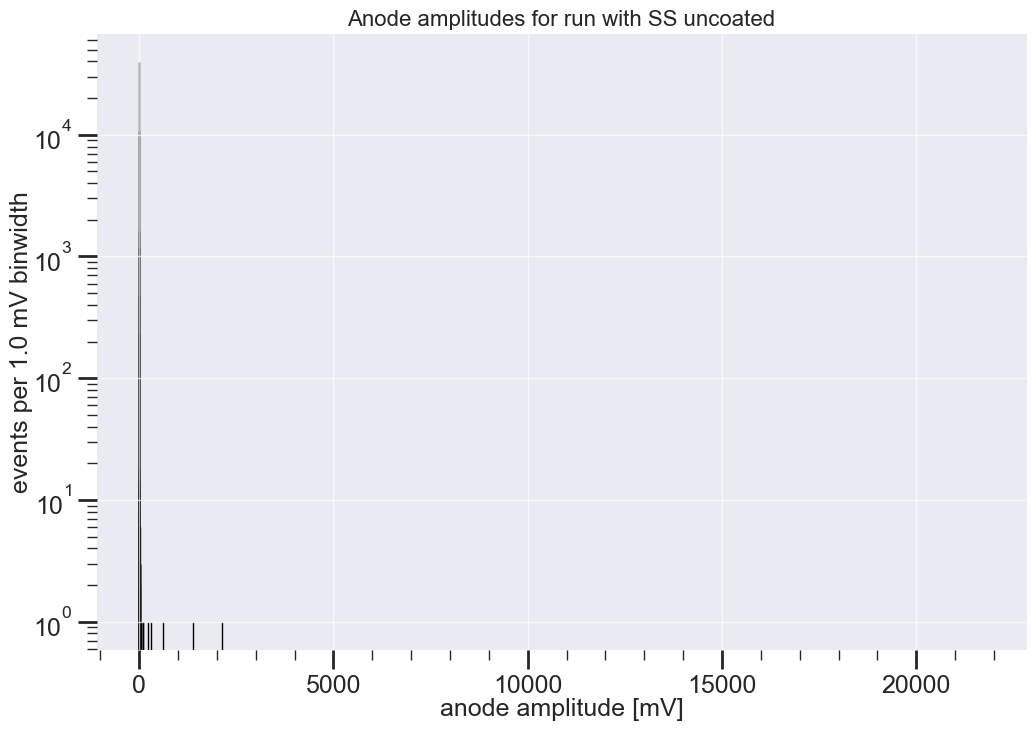

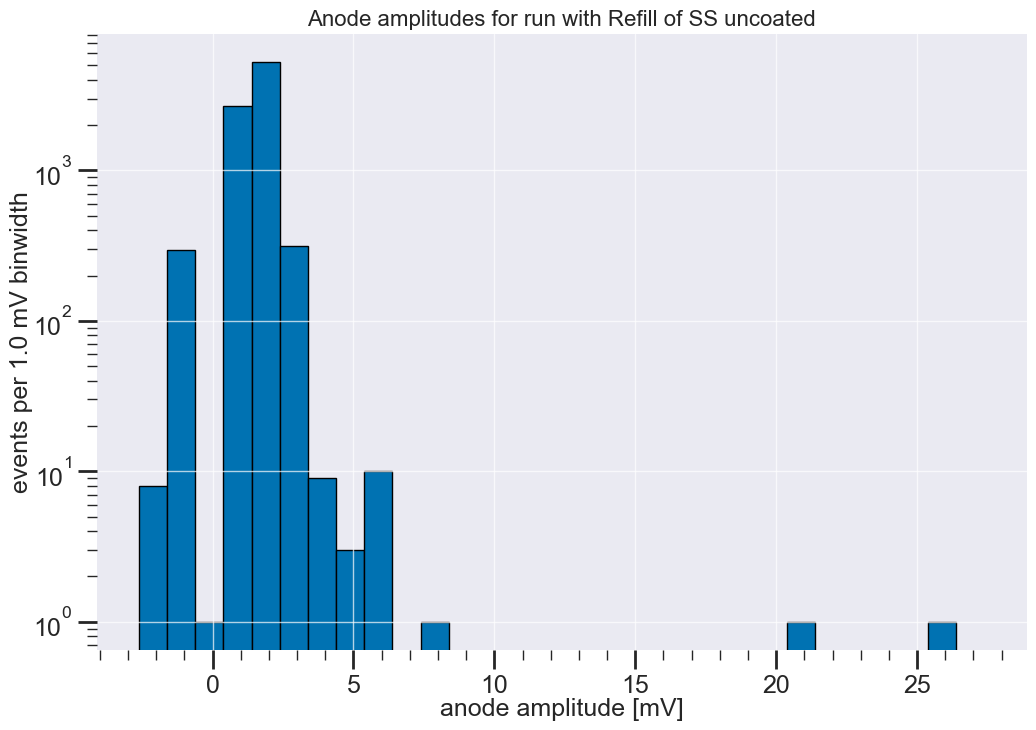

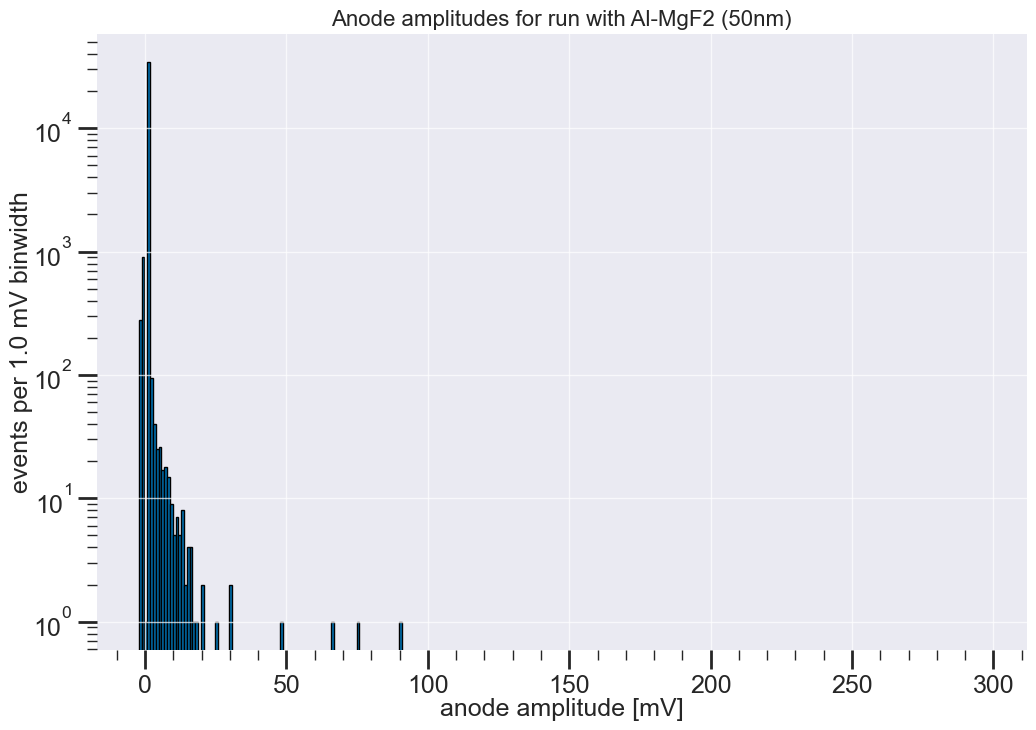

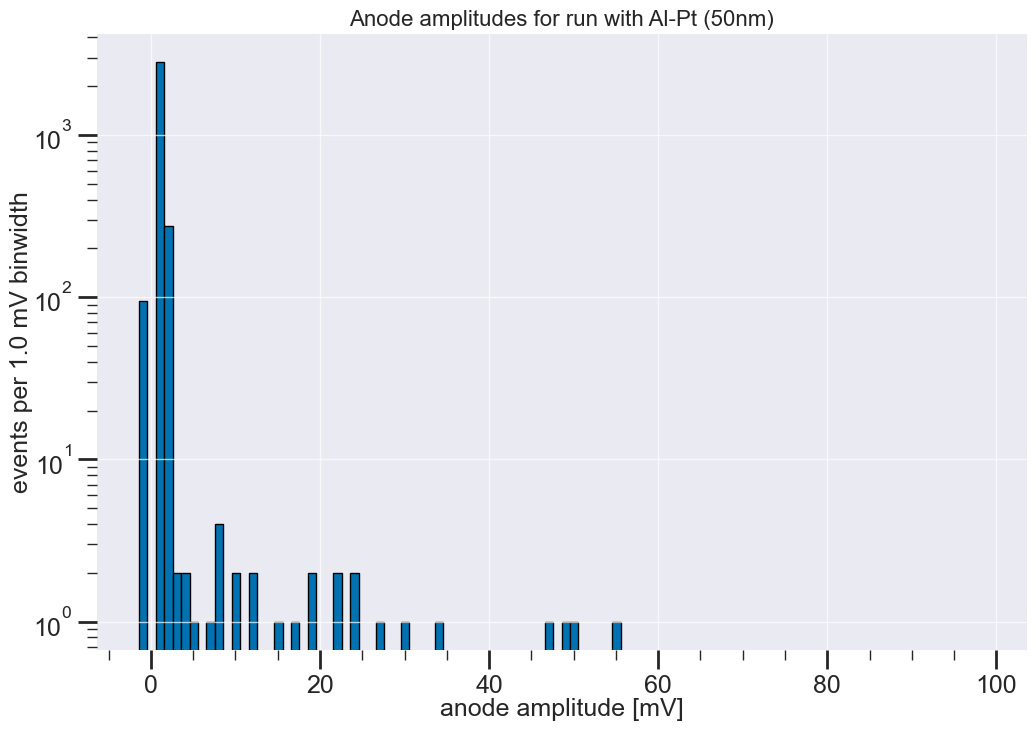

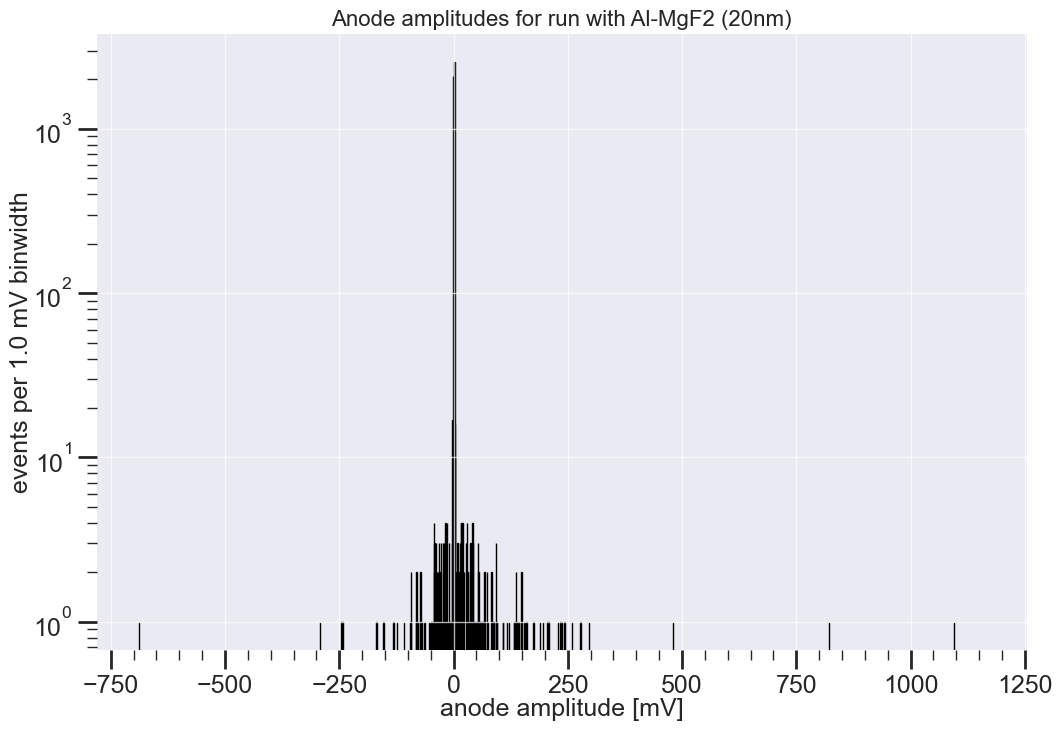

In [7]:
for run, ana in anas.items():
    fig, ax = plt.subplots()
    d = ana.df
    ampdf = d[~d["ch3 amp"].isna()]
    h = np.array(ampdf["ch3 amp"])
    binwidth = 1 #mV
    #protect against huge bounds and misreconstructed amplitudes
    bins = np.arange(np.min(h), np.max(h), binwidth)
    ax.hist(h, bins=bins)

    ax.set_xlabel("anode amplitude [mV]")
    ax.set_ylabel("events per {:.1f} mV binwidth".format(binwidth))
    ax.set_title("Anode amplitudes for run with " + ana.title)
    ax.set_yscale('log')
    plt.show()

## Peak multiplicities

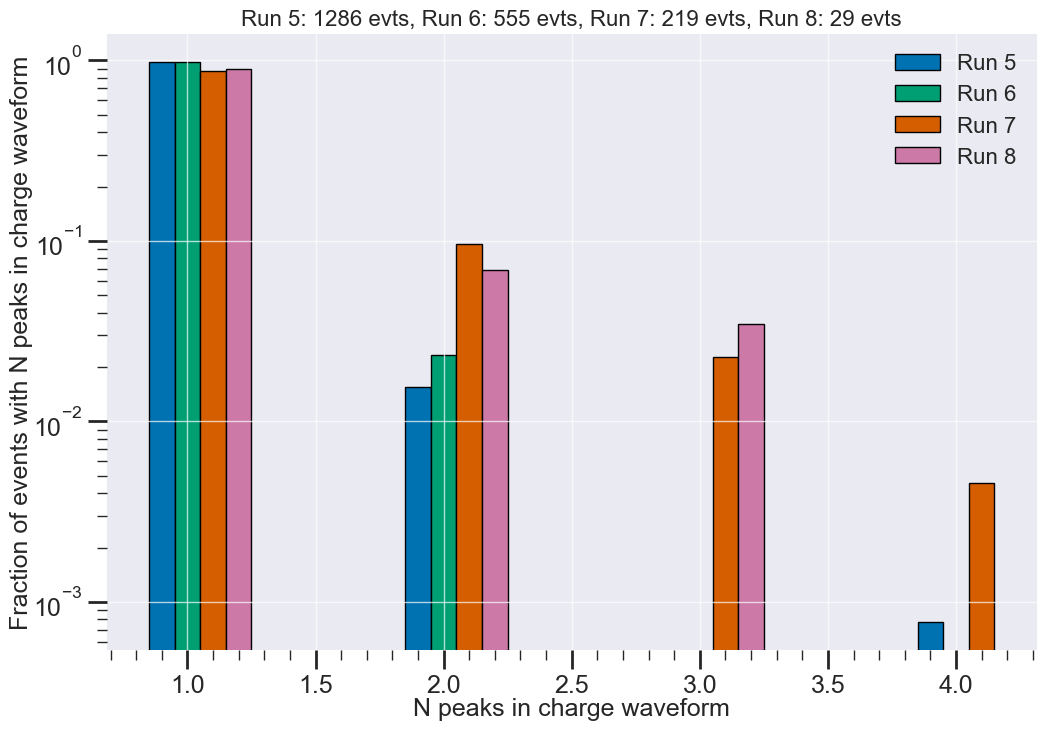

In [16]:
#Multiplicities
fig, ax = plt.subplots()
barwidth = 0.1
total_events_run = {}
for i, (run, ana) in enumerate(anas.items()):
    d = ana.df
    npeaks = np.array(d["ch3 n peaks"])
    npeaks = npeaks[~np.equal(npeaks, None)]
    npeaks_set = list(set(npeaks))
    npeaks_count = {}
    total_nonzero = 0
    for n in npeaks_set:
        npeaks_count[n] = len(np.where(npeaks == n)[0])
        if(n != 0):
            total_nonzero += npeaks_count[n]
    plotlist = []
    for n in npeaks_count:
        if(n == 0): continue
        plotlist.append(npeaks_count[n]/total_nonzero)
    
    total_events_run[run] = total_nonzero


    pos = np.array([_ for _ in npeaks_count if _ != 0])
    ax.bar(pos + (i - 1)*barwidth, plotlist, barwidth, label="Run {:d}".format(run))

ax.legend()
ax.set_yscale('log')
ax.set_ylabel("Fraction of events with N peaks in charge waveform")
ax.set_xlabel("N peaks in charge waveform")
ax.set_title("Run 5: {:d} evts, Run 6: {:d} evts, Run 7: {:d} evts, Run 8: {:d} evts".format(total_events_run[5],total_events_run[6],total_events_run[7], total_events_run[8]))
plt.show()


In [ ]:
#Multiplicities

for i, (run, ana) in enumerate(anas.items()):
    fig, ax = plt.subplots()
    d = ana.df
    npeaks = np.array(d["ch3 n peaks"])
    npeaks = npeaks[~np.equal(npeaks, None)]
    kv = np.array(d["ch3 hv"])
    kv = kv[~np.equal(kv, None)]
    ax.scatter(kv, npeaks, alpha=0.5, s=30)
    

    #ax.legend()
    ax.set_ylabel("N peaks in charge waveform")
    ax.set_xlabel("HV applied [kV]")
    ax.set_title("Run {:d}".format(run))
    #ax.set_xlim([5, 15])
    plt.show()


# Waveform plotting tools, which require cluster operation for access to prereduced

In [ ]:
#waveform plotting tool (not tested, need cluster where all prereduced data sits. )
for run, ana in anas.items():
    d = ana.df
    mask = (d["ch3 amp"] > 20)
    sw_chs = [3]
    events = ana.get_waveforms_from_cuts(mask, sw_chs)[3]
    fig, ax = plt.subplots()
    for ev in events:
        times = np.arange(0, ev["dT"]*1e6*len(ev["Data"][0]), ev["dT"]*1e6)
        ax.plot(times, ev["Data"][0])

    ax.legend()
    ax.set_xlabel("time [us]")
    ax.set_ylabel('[mV]')
    ax.set_title("run {:d} ({:d} events)".format(run, len(events)))
    plt.show()

## History plots

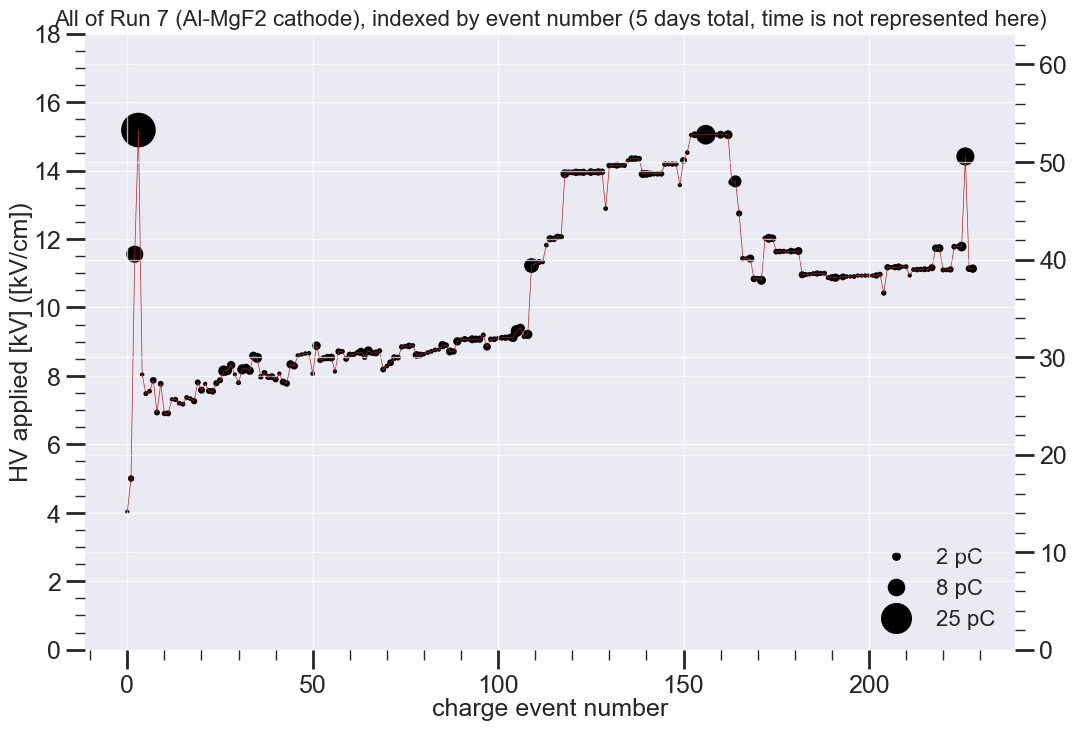

In [114]:
from matplotlib.lines import Line2D
d = anas[7].df
fig, ax = plt.subplots()

mask = (d["ch3 amp"] > 2) & (d["ch3 amp"] != None)
d_ch = np.array(d[mask]["ch3 charge"])
d_sec = np.array(d[mask]["ch3 seconds"])
d_hv = np.array(d[mask]["ch3 hv"])
d_E = np.array(d[mask]["ch3 field"])

#recast time
d_dt = [datetime.fromtimestamp(_) for _ in d_sec]

ax.plot(range(len(d_hv)), d_hv, '-', color='firebrick', linewidth=0.5)
ax.scatter(range(len(d_hv)), d_hv, s=list(np.array(d_ch)*20), color='k')
ax.set_ylim([0, 18])

ax2 = ax.twinx()
E_f = lambda V:V/0.285
ymin, ymax = ax.get_ylim()
ax2.set_ylim(E_f(ymin), E_f(ymax))
ax2.plot([], [])
ax2.set_ylabel("Field in the gap [kV/cm]")

# Define custom legend entries with markers
legend_elements = [
    Line2D([0], [0], marker='o', linewidth=0, color='k', markersize=np.sqrt(2*20), label='2 pC'),
    Line2D([0], [0], marker='o', linewidth=0, color='k', markersize=np.sqrt(8*20), label='8 pC'),
    Line2D([0], [0], marker='o', linewidth=0, color='k', markersize=np.sqrt(25*20), label='25 pC'),
]

# Add legend with custom legend entries
ax.legend(handles=legend_elements, loc='lower right')

ax.set_xlabel("charge event number")
ax.set_ylabel("HV applied [kV] ([kV/cm])")
ax.set_title("All of Run 7 (Al-MgF2 cathode), indexed by event number (5 days total, time is not represented here)")
plt.show()

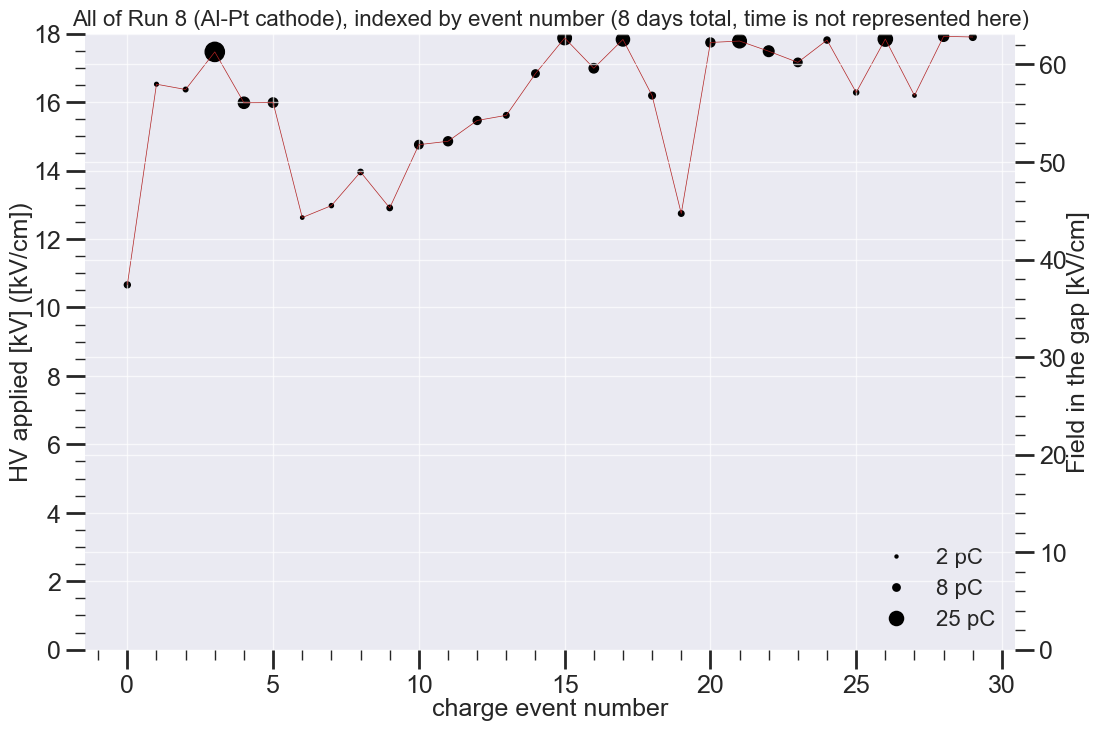

In [115]:
from matplotlib.lines import Line2D
d = anas[8].df
fig, ax = plt.subplots()

mask = (d["ch3 amp"] > 2) & (d["ch3 amp"] != None)
d_ch = np.array(d[mask]["ch3 charge"])
d_sec = np.array(d[mask]["ch3 seconds"])
d_hv = np.array(d[mask]["ch3 hv"])
d_E = np.array(d[mask]["ch3 field"])

#recast time
d_dt = [datetime.fromtimestamp(_) for _ in d_sec]

ax.plot(range(len(d_hv)), d_hv, '-', color='firebrick', linewidth=0.5)
ax.scatter(range(len(d_hv)), d_hv, s=list(np.array(d_ch)*20), color='k')
ax.set_ylim([0, 18])

#field values are printed alongside the same ticks on the voltage axis
ax2 = ax.twinx()
E_f = lambda V:V/0.285
ymin, ymax = ax.get_ylim()
ax2.set_ylim(E_f(ymin), E_f(ymax))
ax2.plot([], [])
ax2.set_ylabel("Field in the gap [kV/cm]")


# Define custom legend entries with markers
legend_elements = [
    Line2D([0], [0], marker='o', linewidth=0, color='k', markersize=np.sqrt(2*20)/2, label='2 pC'),
    Line2D([0], [0], marker='o', linewidth=0, color='k', markersize=np.sqrt(8*20)/2, label='8 pC'),
    Line2D([0], [0], marker='o', linewidth=0, color='k', markersize=np.sqrt(25*20)/2, label='25 pC'),
]

# Add legend with custom legend entries
ax.legend(handles=legend_elements, loc='lower right')

ax.set_xlabel("charge event number")
ax.set_ylabel("HV applied [kV] ([kV/cm])")
ax.set_title("All of Run 8 (Al-Pt cathode), indexed by event number (8 days total, time is not represented here)")
plt.show()

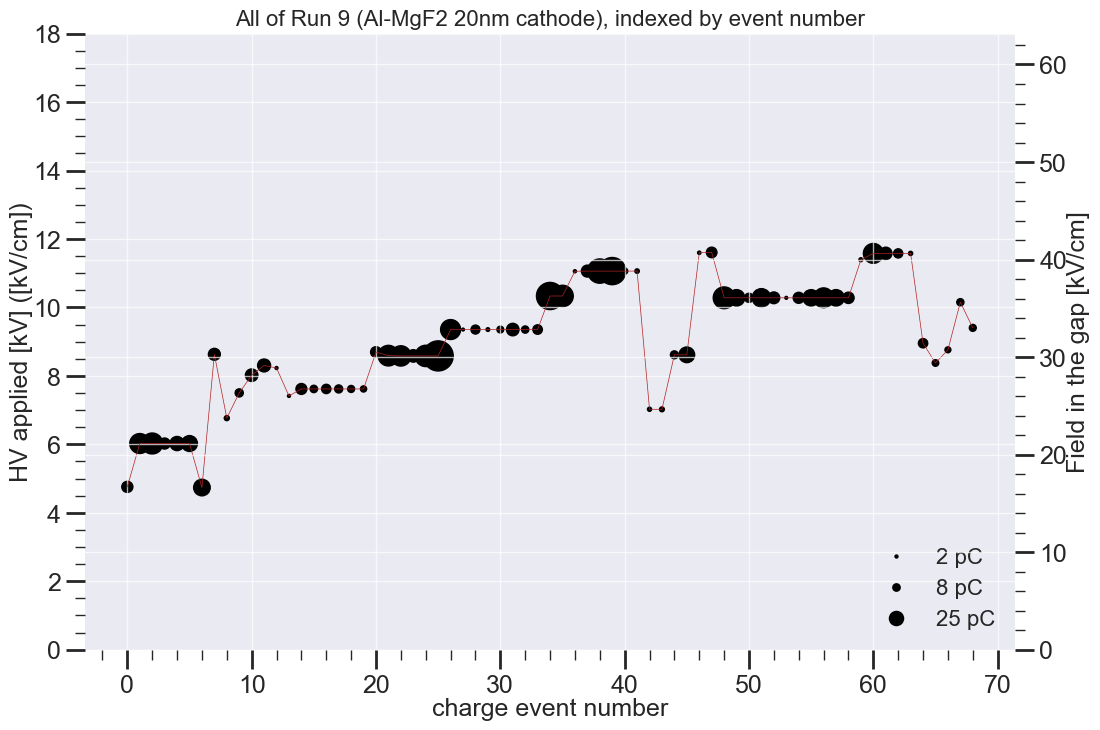

In [4]:
from matplotlib.lines import Line2D
d = anas[9].df
fig, ax = plt.subplots()

mask = (d["ch3 amp"] > 2) & (d["ch3 amp"] != None)
d_ch = np.array(d[mask]["ch3 charge"])
d_sec = np.array(d[mask]["ch3 seconds"])
d_hv = np.array(d[mask]["ch3 hv"])
d_E = np.array(d[mask]["ch3 field"])

#recast time
d_dt = [datetime.fromtimestamp(_) for _ in d_sec]

ax.plot(range(len(d_hv)), d_hv, '-', color='firebrick', linewidth=0.5)
ax.scatter(range(len(d_hv)), d_hv, s=list(np.array(d_ch)*20), color='k')
ax.set_ylim([0, 18])

#field values are printed alongside the same ticks on the voltage axis
ax2 = ax.twinx()
E_f = lambda V:V/0.285
ymin, ymax = ax.get_ylim()
ax2.set_ylim(E_f(ymin), E_f(ymax))
ax2.plot([], [])
ax2.set_ylabel("Field in the gap [kV/cm]")


# Define custom legend entries with markers
legend_elements = [
    Line2D([0], [0], marker='o', linewidth=0, color='k', markersize=np.sqrt(2*20)/2, label='2 pC'),
    Line2D([0], [0], marker='o', linewidth=0, color='k', markersize=np.sqrt(8*20)/2, label='8 pC'),
    Line2D([0], [0], marker='o', linewidth=0, color='k', markersize=np.sqrt(25*20)/2, label='25 pC'),
]

# Add legend with custom legend entries
ax.legend(handles=legend_elements, loc='lower right')

ax.set_xlabel("charge event number")
ax.set_ylabel("HV applied [kV] ([kV/cm])")
ax.set_title("All of Run 9 (Al-MgF2 20nm cathode), indexed by event number")
plt.show()

# Drafting

/Users/ejangelico/Documents/Stanford/GasBreakdownChamber/code/ad2-data-processing/notebooks/../AnalysisTools/AnalysisTools.py:126: UserWarning: genfromtxt: Empty input file: "../../data/Run8/ds03/g_events.txt"
  if(len(d.shape) == 1):


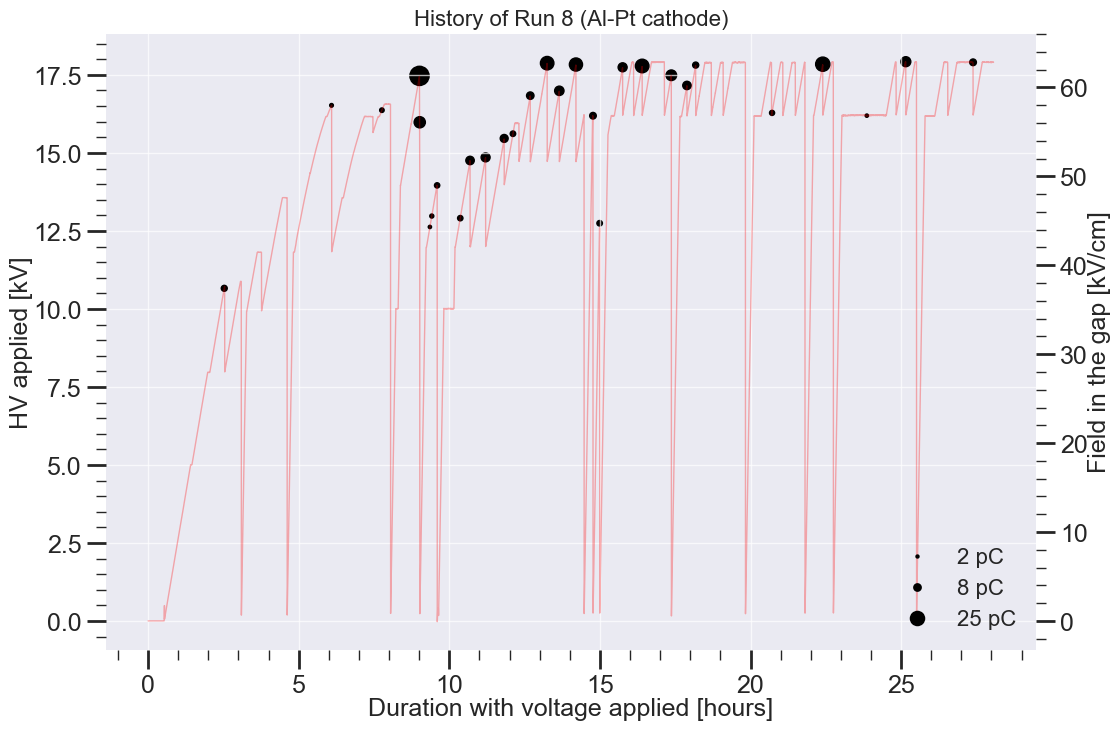

In [101]:
ana = anas[8]
d = ana.df
ana.load_hv_textfiles()
ana.identify_ramps(ref='v_mon')
#an attempt to make code that will give me the HV ramp curve along with
#amplitudes and times of any charge  signals that arrive
fig, ax = plt.subplots()
tdmap = ana.time_duration_map
ax.plot(np.array(tdmap["dur"])/3600, tdmap["v"], 'r-', linewidth=1, alpha=0.3)

mask = (d["ch3 amp"] > 2) & (d["ch3 amp"] != None)
d_ch = np.array(d[mask]["ch3 charge"])
d_sec = np.array(d[mask]["ch3 seconds"])
d_hv = np.array(d[mask]["ch3 hv"])
d_E = np.array(d[mask]["ch3 field"])

#recast time
hv_event_durs = [ana.get_duration_from_timestamp(_)/3600 for _ in d_sec]
ax.scatter(hv_event_durs, d_hv, s=list(np.array(d_ch)*20), color='k')

ax2 = ax.twinx()
E_f = lambda V:V/0.285
ymin, ymax = ax.get_ylim()
ax2.set_ylim(E_f(ymin), E_f(ymax))
ax2.plot([], [])

# Define custom legend entries with markers
legend_elements = [
    Line2D([0], [0], marker='o', linewidth=0, color='k', markersize=np.sqrt(2*20)/2, label='2 pC'),
    Line2D([0], [0], marker='o', linewidth=0, color='k', markersize=np.sqrt(8*20)/2, label='8 pC'),
    Line2D([0], [0], marker='o', linewidth=0, color='k', markersize=np.sqrt(25*20)/2, label='25 pC'),
]

# Add legend with custom legend entries
ax.legend(handles=legend_elements, loc='lower right')
ax.set_ylabel("HV applied [kV]")
ax2.set_ylabel("Field in the gap [kV/cm]")
ax2.grid(False)
ax.set_xlabel("Duration with voltage applied [hours]")
ax.set_title("History of Run 8 (Al-Pt cathode)")
plt.show()

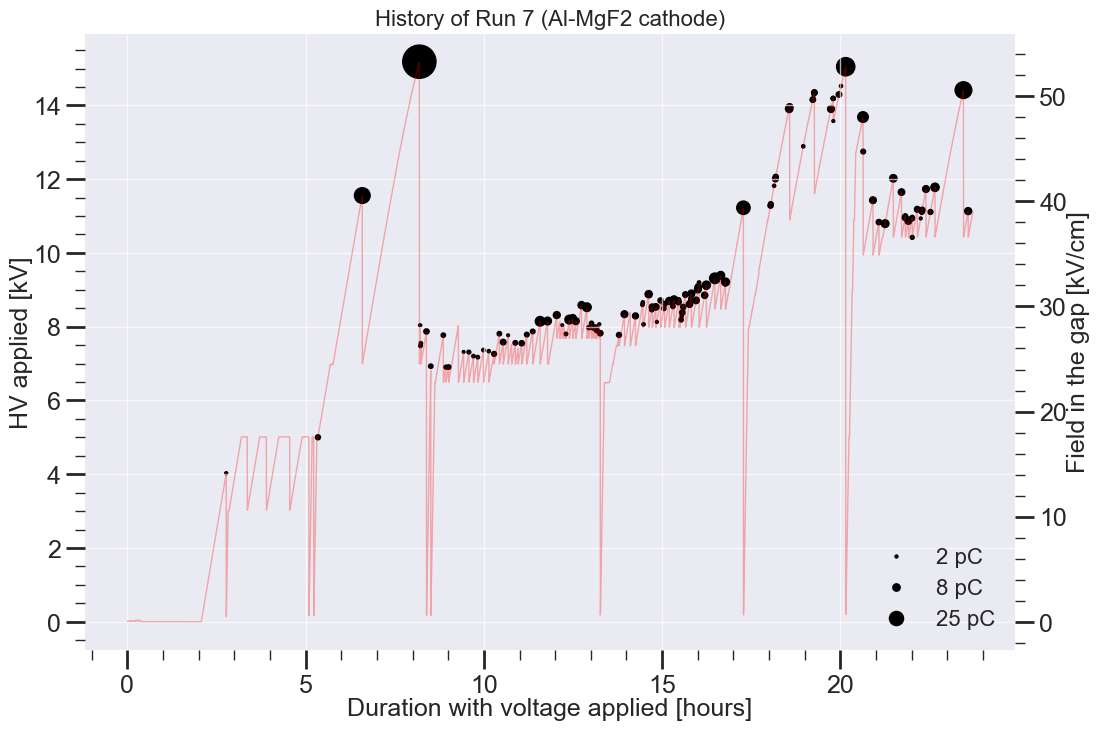

In [103]:
ana = anas[7]
d = ana.df
ana.load_hv_textfiles()
ana.identify_ramps(ref='v_mon')
#an attempt to make code that will give me the HV ramp curve along with
#amplitudes and times of any charge  signals that arrive
fig, ax = plt.subplots()
tdmap = ana.time_duration_map
ax.plot(np.array(tdmap["dur"])/3600, tdmap["v"], 'r-', linewidth=1, alpha=0.3)


mask = (d["ch3 amp"] > 2) & (d["ch3 amp"] != None)
d_ch = np.array(d[mask]["ch3 charge"])
d_sec = np.array(d[mask]["ch3 seconds"])
d_hv = np.array(d[mask]["ch3 hv"])
d_E = np.array(d[mask]["ch3 field"])

#recast time
hv_event_durs = [ana.get_duration_from_timestamp(_)/3600 for _ in d_sec]
ax.scatter(hv_event_durs, d_hv, s=list(np.array(d_ch)*20), color='k')

ax2 = ax.twinx()
E_f = lambda V:V/0.285
ymin, ymax = ax.get_ylim()
ax2.set_ylim(E_f(ymin), E_f(ymax))
ax2.plot([], [])

# Define custom legend entries with markers
legend_elements = [
    Line2D([0], [0], marker='o', linewidth=0, color='k', markersize=np.sqrt(2*20)/2, label='2 pC'),
    Line2D([0], [0], marker='o', linewidth=0, color='k', markersize=np.sqrt(8*20)/2, label='8 pC'),
    Line2D([0], [0], marker='o', linewidth=0, color='k', markersize=np.sqrt(25*20)/2, label='25 pC'),
]

# Add legend with custom legend entries
ax.legend(handles=legend_elements, loc='lower right')
ax.set_ylabel("HV applied [kV]")
ax2.set_ylabel("Field in the gap [kV/cm]")
ax2.grid(False)
ax.set_xlabel("Duration with voltage applied [hours]")
ax.set_title("History of Run 7 (Al-MgF2 cathode)")
plt.show()

/Users/ejangelico/Documents/Stanford/GasBreakdownChamber/code/ad2-data-processing/notebooks/../AnalysisTools/AnalysisTools.py:127: UserWarning: genfromtxt: Empty input file: "../../data/Run8/ds03/g_events.txt"
  #there is a silly thing with genfromtxt where if its a 1 line file, it makes a 1D array instead of the usual


NameError: name 'Line2D' is not defined

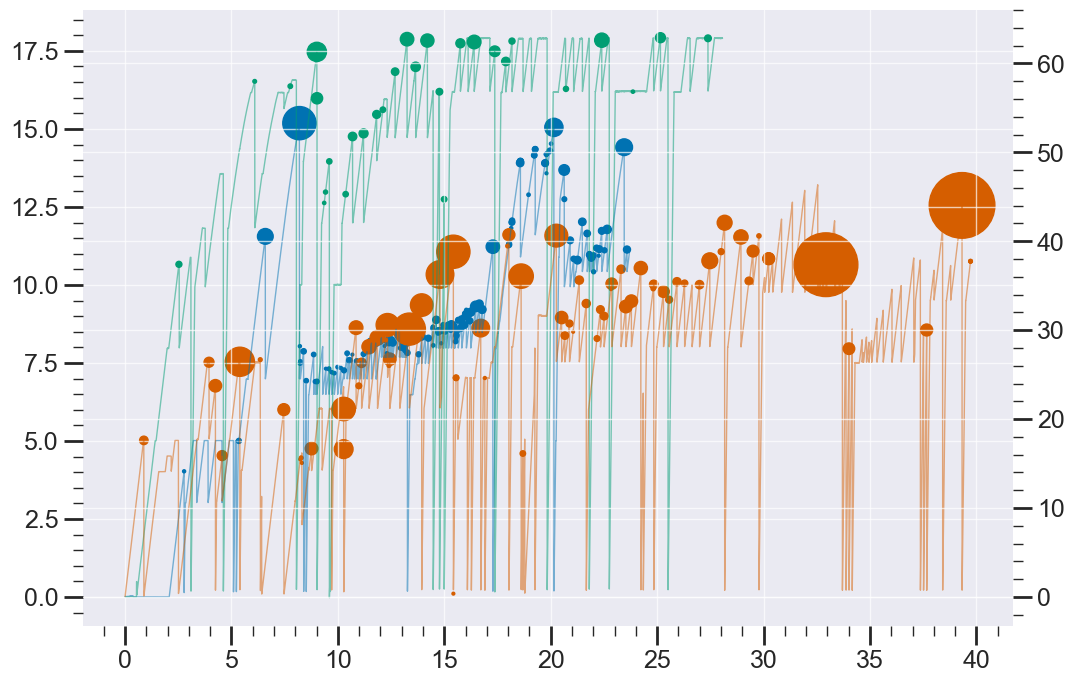

In [8]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

ana = anas[7]
d = ana.df
ana.load_hv_textfiles()
ana.identify_ramps(ref='v_mon')
#an attempt to make code that will give me the HV ramp curve along with
#amplitudes and times of any charge  signals that arrive
fig, ax = plt.subplots()
tdmap = ana.time_duration_map
ax.plot(np.array(tdmap["dur"])/3600, tdmap["v"], color=colors[0], linewidth=1, alpha=0.5)


mask = (d["ch3 amp"] > 2) & (d["ch3 amp"] != None)
d_ch = np.array(d[mask]["ch3 charge"])
d_sec = np.array(d[mask]["ch3 seconds"])
d_hv = np.array(d[mask]["ch3 hv"])
d_E = np.array(d[mask]["ch3 field"])

#recast time
hv_event_durs = [ana.get_duration_from_timestamp(_)/3600 for _ in d_sec]
ax.scatter(hv_event_durs, d_hv, s=list(np.array(d_ch)*20), color=colors[0], alpha=1)

ana = anas[8]
d = ana.df
ana.load_hv_textfiles()
ana.identify_ramps(ref='v_mon')
#an attempt to make code that will give me the HV ramp curve along with
#amplitudes and times of any charge  signals that arrive
tdmap = ana.time_duration_map
ax.plot(np.array(tdmap["dur"])/3600, tdmap["v"], color=colors[1], linewidth=1, alpha=0.5)


mask = (d["ch3 amp"] > 2) & (d["ch3 amp"] != None)
d_ch = np.array(d[mask]["ch3 charge"])
d_sec = np.array(d[mask]["ch3 seconds"])
d_hv = np.array(d[mask]["ch3 hv"])
d_E = np.array(d[mask]["ch3 field"])

#recast time
hv_event_durs = [ana.get_duration_from_timestamp(_)/3600 for _ in d_sec]
ax.scatter(hv_event_durs, d_hv, s=list(np.array(d_ch)*20), color=colors[1], alpha=1)



ana = anas[9]
d = ana.df
ana.load_hv_textfiles()
ana.identify_ramps(ref='v_mon')
#an attempt to make code that will give me the HV ramp curve along with
#amplitudes and times of any charge  signals that arrive
tdmap = ana.time_duration_map
ax.plot(np.array(tdmap["dur"])/3600, tdmap["v"], color=colors[2], linewidth=1, alpha=0.5)


mask = (d["ch3 amp"] > 2) & (d["ch3 amp"] != None)
d_ch = np.array(d[mask]["ch3 charge"])
d_sec = np.array(d[mask]["ch3 seconds"])
d_hv = np.array(d[mask]["ch3 hv"])
d_E = np.array(d[mask]["ch3 field"])

#recast time
hv_event_durs = [ana.get_duration_from_timestamp(_)/3600 for _ in d_sec]
ax.scatter(hv_event_durs, d_hv, s=list(np.array(d_ch)*20), color=colors[2], alpha=1)

ax2 = ax.twinx()
E_f = lambda V:V/0.285
ymin, ymax = ax.get_ylim()
ax2.set_ylim(E_f(ymin), E_f(ymax))
ax2.plot([], [])

# Define custom legend entries with markers
legend_elements = [
    Line2D([0], [0], marker='o', linewidth=0, color='k', markersize=np.sqrt(2*20)/2, label='2 pC'),
    Line2D([0], [0], marker='o', linewidth=0, color='k', markersize=np.sqrt(8*20)/2, label='8 pC'),
    Line2D([0], [0], marker='o', linewidth=0, color='k', markersize=np.sqrt(25*20)/2, label='25 pC'),
    Line2D([0], [0], marker='o', linewidth=0, color=colors[0], markersize=np.sqrt(25*20)/2, label='Al-MgF2 50nm'),
    Line2D([0], [0], marker='o', linewidth=0, color=colors[1], markersize=np.sqrt(25*20)/2, label='Al-Pt'),
    Line2D([0], [0], marker='o', linewidth=0, color=colors[2], markersize=np.sqrt(25*20)/2, label='Al-MgF2 20nm')
]

# Add legend with custom legend entries
ax.legend(handles=legend_elements, loc='lower right')
ax.set_ylabel("HV applied [kV]")
ax2.set_ylabel("Field in the gap [kV/cm]")
ax2.grid(False)
ax.set_xlabel("Duration with voltage applied [hours]")
ax.set_title("Runs compared: charge events as circles, high voltage applied as lines")
plt.show()

## Comparisons with analytic stored charge and energy

In [10]:
C = 20 #pF
cq = 1.6e-19

dQs = np.array(np.linspace(0.5, 50, 100)) #pC
Vs = np.array(np.linspace(0, 18, 100)) #kV
Es = Vs/0.285
Qs = C*Vs*1000 #pC

U = 0.5*(Qs**2)/(C*1e6) #uJ

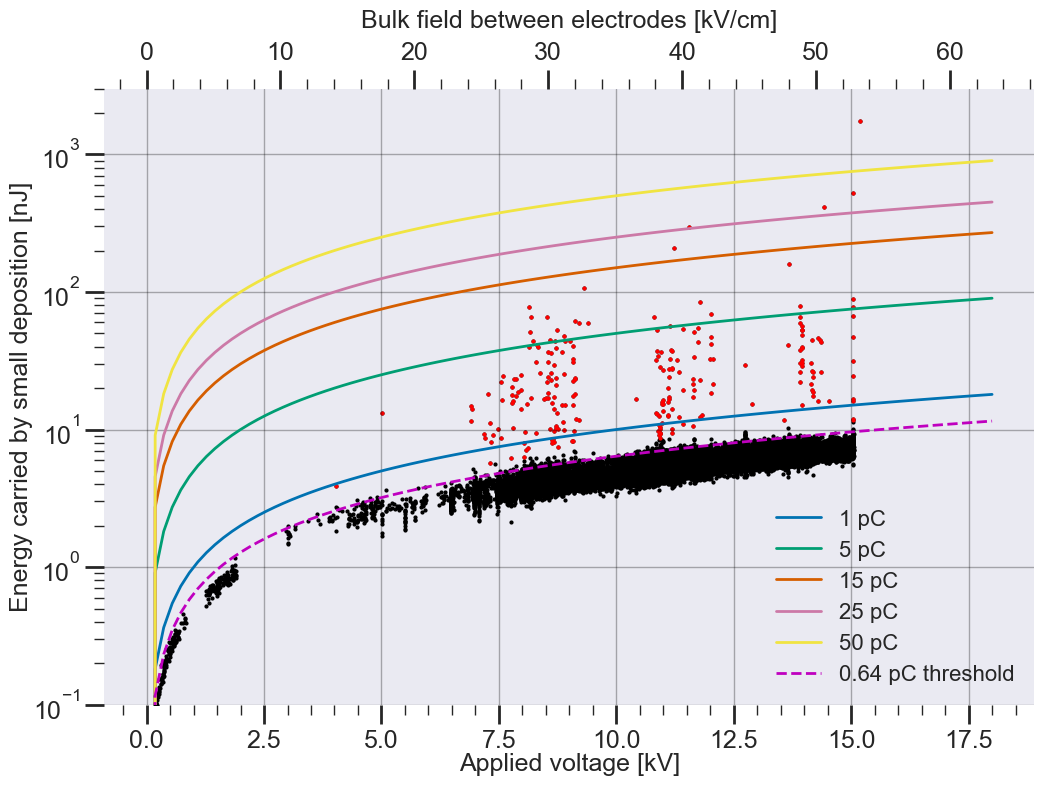

In [57]:
#get charge magnitudes and calculate partial energy
#deposited for each charge event in a run based on what
#voltage / total stored charge is in the gap at that moment. 




dQs = [1, 5, 15, 25, 50]
fig, ax = plt.subplots()
ax2 = ax.twiny()
for dq in dQs:
    dU = dq*Qs/(C*1e6) #uJ
    ax.plot(Vs, dU*1000, label="{:d} pC".format(dq))
    ax2.plot(Es, dU*1000, linewidth=0)

d = anas[7].df
hardware_threshold = 0.64 #pC
mask = (~d["ch3 energy"].isna()) 
du_evts = d[mask]
ax.scatter(np.array(du_evts["ch3 hv"]), np.array(du_evts["ch3 energy"]), color='k')
ax.plot(Vs, hardware_threshold*Vs, 'm--', label="{:.2f} pC threshold".format(hardware_threshold))

#above trip threshold, color differently. 
mask = (~d["ch3 energy"].isna()) & (d["ch3 amp"] > 2)
du_evts = d[mask]
ax.scatter(np.array(du_evts["ch3 hv"]), np.array(du_evts["ch3 energy"]), color='r')


ax2.grid(False)
ax2.set_xlabel("Bulk field between electrodes [kV/cm]", labelpad=10)
ax.set_xlabel("Applied voltage [kV]")
ax.set_ylabel("Energy carried by small deposition [nJ]")
ax.grid(color='k', alpha=0.3)
ax.set_yscale('log')
ax.set_ylim([1e-1, 3e3])
ax.legend()
plt.show()

/var/folders/nr/f5dqj57n2yg5k0j2_ffmgmzm0000gn/T/ipykernel_24648/2008372124.py:14: RuntimeWarning: invalid value encountered in divide
  ax.plot(Vs, dU/U, label="{:d} pC".format(dq))
/var/folders/nr/f5dqj57n2yg5k0j2_ffmgmzm0000gn/T/ipykernel_24648/2008372124.py:15: RuntimeWarning: invalid value encountered in divide
  ax2.plot(Es, dU/U, linewidth=0)
/var/folders/nr/f5dqj57n2yg5k0j2_ffmgmzm0000gn/T/ipykernel_24648/2008372124.py:33: RuntimeWarning: invalid value encountered in divide
  ax.plot(Vs, hardware_threshold*Vs*1000/(0.5*C*((Vs*1000)**2)), 'm--', label="{:.2f} pC threshold".format(hardware_threshold))


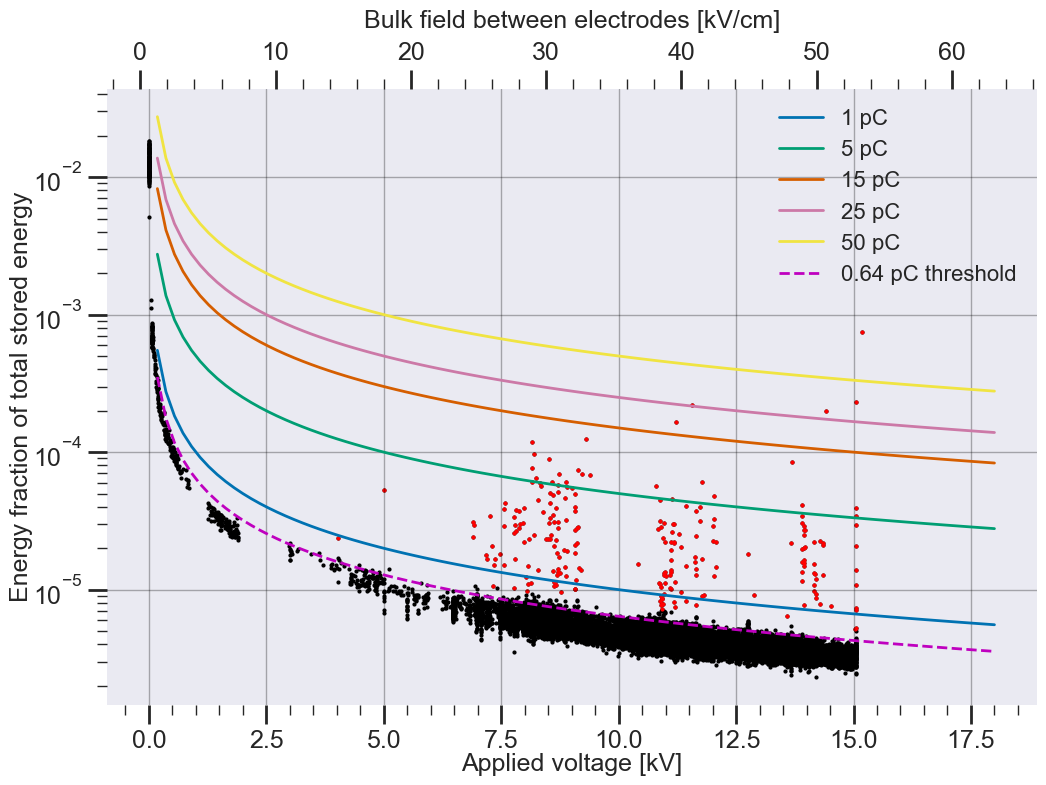

In [53]:
#get charge magnitudes and calculate partial energy
#deposited for each charge event in a run based on what
#voltage / total stored charge is in the gap at that moment. 

#Do the same as above but normalize relative to the total energy stored in the cap. 
#i.e. calculate fractional energy carried relative to the total energy. 


dQs = [1, 5, 15, 25, 50]
fig, ax = plt.subplots()
ax2 = ax.twiny()
for dq in dQs:
    dU = dq*Qs/(C*1e6) #uJ
    ax.plot(Vs, dU/U, label="{:d} pC".format(dq))
    ax2.plot(Es, dU/U, linewidth=0)


d = anas[7].df

mask = (~d["ch3 energy"].isna())
du_evts = d[mask]
total_energy = 0.5*C*(np.array(du_evts["ch3 hv"])*1000)**2
ax.scatter(np.array(du_evts["ch3 hv"]), np.array(du_evts["ch3 energy"])*1000/total_energy, color='k')

#above trip threshold, color differently. 
mask = (~d["ch3 energy"].isna()) & (d["ch3 amp"] > 2)
du_evts = d[mask]
total_energy = 0.5*C*(np.array(du_evts["ch3 hv"])*1000)**2
ax.scatter(np.array(du_evts["ch3 hv"]), np.array(du_evts["ch3 energy"])*1000/total_energy, color='r')


hardware_threshold = 0.64 #pC
ax.plot(Vs, hardware_threshold*Vs*1000/(0.5*C*((Vs*1000)**2)), 'm--', label="{:.2f} pC threshold".format(hardware_threshold))


ax2.grid(False)
ax2.set_xlabel("Bulk field between electrodes [kV/cm]", labelpad=10)
ax.set_xlabel("Applied voltage [kV]")
ax.set_ylabel("Energy fraction of total stored energy")
ax.grid(color='k', alpha=0.3)
ax.set_yscale('log')
#ax.set_ylim([1e-1, 3e3])
ax.legend()
plt.show()

/var/folders/nr/f5dqj57n2yg5k0j2_ffmgmzm0000gn/T/ipykernel_49349/1074455559.py:8: RuntimeWarning: divide by zero encountered in divide
  ax.plot(Vs, hardware_threshold/Qs, 'm--',  label="{:.2f} pC threshold".format(hardware_threshold))


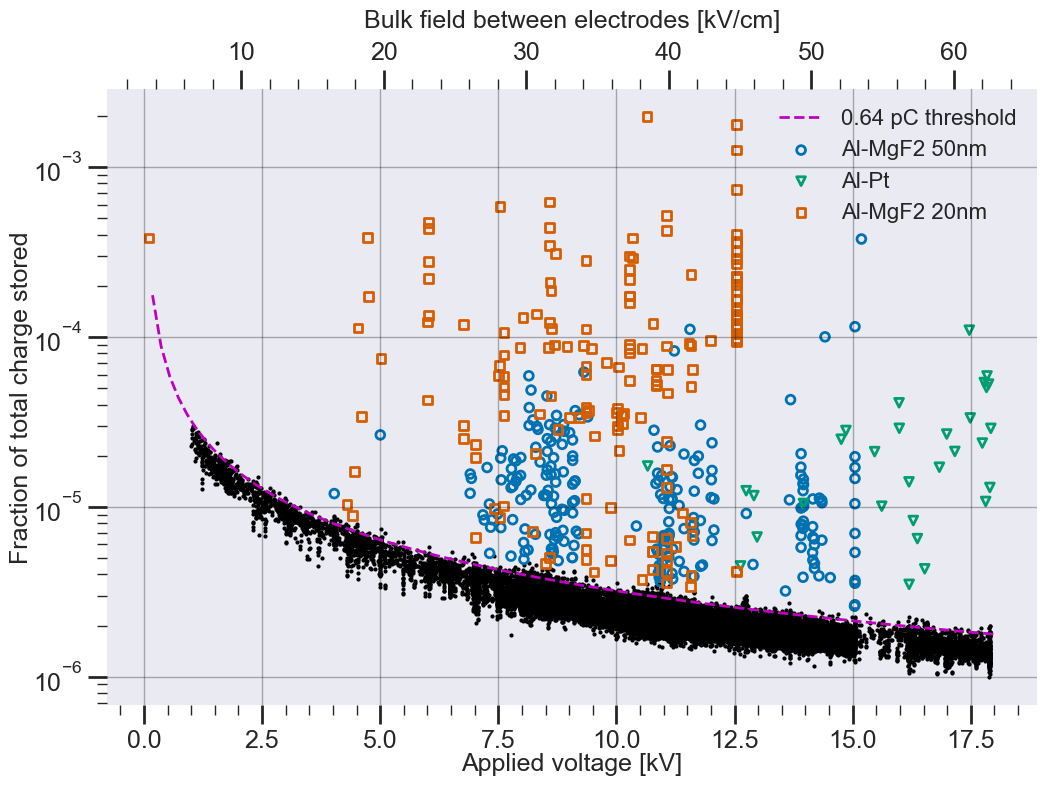

In [11]:
#similar as above, but now fractional stored charge. 

fig, ax = plt.subplots()


ax2 = ax.twiny()
hardware_threshold = 0.64 #pC
ax.plot(Vs, hardware_threshold/Qs, 'm--',  label="{:.2f} pC threshold".format(hardware_threshold))

d = anas[7].df

mask = (~d["ch3 energy"].isna()) & (d["ch3 hv"] > 1)& (d["ch3 amp"] < 2)
du_evts = d[mask]

total_q = np.array(du_evts["ch3 hv"])*1000*C
ax.scatter(np.array(du_evts["ch3 hv"]), np.array(du_evts["ch3 charge"])/total_q, color='k')
ax2.scatter(np.array(du_evts["ch3 field"]), np.array(du_evts["ch3 charge"])/total_q, color='k', alpha=0)


mask = (~d["ch3 energy"].isna()) & (d["ch3 amp"] > 2)
du_evts = d[mask]

total_q = np.array(du_evts["ch3 hv"])*1000*C
ax.scatter(np.array(du_evts["ch3 hv"]), np.array(du_evts["ch3 charge"])/total_q, marker='o', linewidth=2, facecolors='None', s=40, edgecolors=colors[0], label="Al-MgF2 50nm")


d = anas[8].df

mask = (~d["ch3 energy"].isna()) & (d["ch3 hv"] > 1)& (d["ch3 amp"] < 2)
du_evts = d[mask]

total_q = np.array(du_evts["ch3 hv"])*1000*C
ax.scatter(np.array(du_evts["ch3 hv"]), np.array(du_evts["ch3 charge"])/total_q, color='k')
ax2.scatter(np.array(du_evts["ch3 field"]), np.array(du_evts["ch3 charge"])/total_q, color='k', alpha=0)


mask = (~d["ch3 energy"].isna()) & (d["ch3 amp"] > 2)
du_evts = d[mask]

total_q = np.array(du_evts["ch3 hv"])*1000*C
ax.scatter(np.array(du_evts["ch3 hv"]), np.array(du_evts["ch3 charge"])/total_q, marker='v', linewidth=2, facecolors='None', s=40, edgecolors=colors[1], label="Al-Pt")

d = anas[9].df

mask = (~d["ch3 energy"].isna()) & (d["ch3 hv"] > 1) & (d["ch3 amp"] < 2)
du_evts = d[mask]

total_q = np.array(du_evts["ch3 hv"])*1000*C
ax.scatter(np.array(du_evts["ch3 hv"]), np.array(du_evts["ch3 charge"])/total_q, color='k')
ax2.scatter(np.array(du_evts["ch3 field"]), np.array(du_evts["ch3 charge"])/total_q, color='k', alpha=0)


mask = (~d["ch3 energy"].isna()) & (d["ch3 amp"] > 2)
du_evts = d[mask]

total_q = np.array(du_evts["ch3 hv"])*1000*C
ax.scatter(np.array(du_evts["ch3 hv"]), np.array(du_evts["ch3 charge"])/total_q, marker='s', linewidth=2, facecolors='None', s=40, edgecolors=colors[2], label="Al-MgF2 20nm")



ax2.grid(False)
ax2.set_xlabel("Bulk field between electrodes [kV/cm]", labelpad=10)
ax.set_xlabel("Applied voltage [kV]")
ax.set_ylabel("Fraction of total charge stored")
ax.legend()
ax.grid(color='k', alpha=0.3)
ax.set_yscale("log")
plt.show()

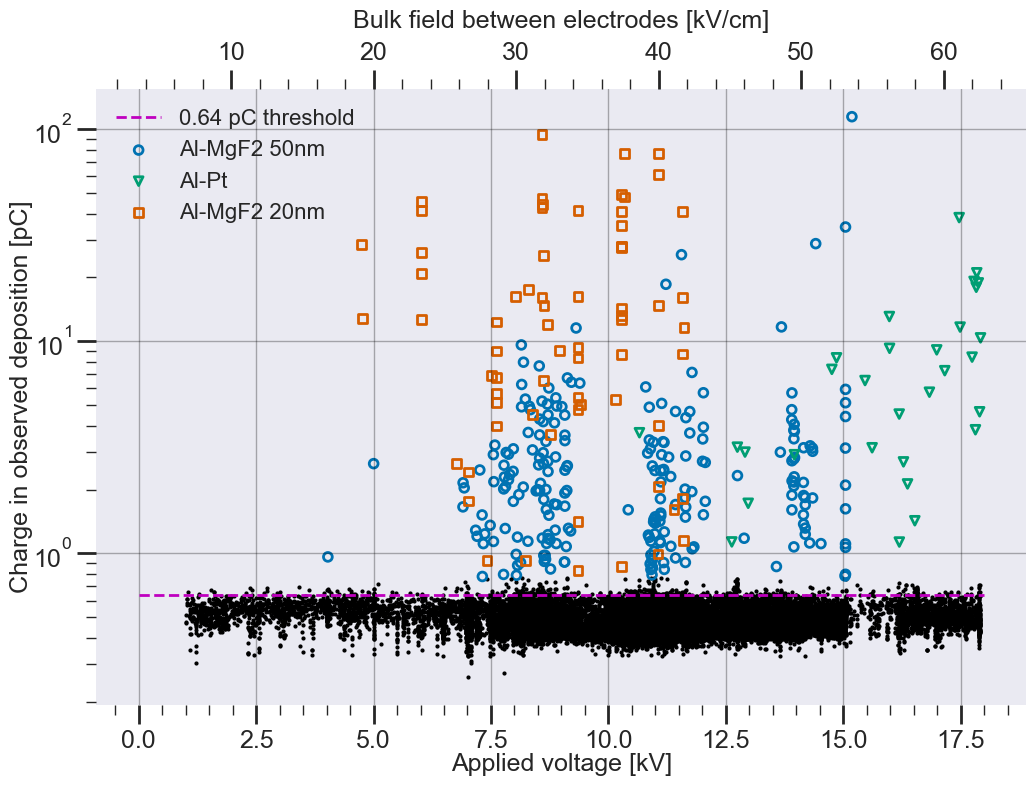

In [71]:
#similar as above, but now stored charge.

fig, ax = plt.subplots()


ax2 = ax.twiny()
hardware_threshold = 0.64 #pC
ax.plot(Vs, [hardware_threshold]*len(Vs), 'm--',  label="{:.2f} pC threshold".format(hardware_threshold))

d = anas[7].df

mask = (~d["ch3 energy"].isna()) & (d["ch3 hv"] > 1)& (d["ch3 amp"] < 2)
du_evts = d[mask]

ax.scatter(np.array(du_evts["ch3 hv"]), np.array(du_evts["ch3 charge"]), color='k')
ax2.scatter(np.array(du_evts["ch3 field"]), np.array(du_evts["ch3 charge"]), color='k', alpha=0)


mask = (~d["ch3 energy"].isna()) & (d["ch3 amp"] > 2)
du_evts = d[mask]

ax.scatter(np.array(du_evts["ch3 hv"]), np.array(du_evts["ch3 charge"]), marker='o', linewidth=2, facecolors='None', s=40, edgecolors=colors[0], label="Al-MgF2 50nm")


d = anas[8].df

mask = (~d["ch3 energy"].isna()) & (d["ch3 hv"] > 1)& (d["ch3 amp"] < 2)
du_evts = d[mask]

ax.scatter(np.array(du_evts["ch3 hv"]), np.array(du_evts["ch3 charge"]), color='k')
ax2.scatter(np.array(du_evts["ch3 field"]), np.array(du_evts["ch3 charge"]), color='k', alpha=0)


mask = (~d["ch3 energy"].isna()) & (d["ch3 amp"] > 2)
du_evts = d[mask]

ax.scatter(np.array(du_evts["ch3 hv"]), np.array(du_evts["ch3 charge"]), marker='v', linewidth=2, facecolors='None', s=40, edgecolors=colors[1], label="Al-Pt")

d = anas[9].df

mask = (~d["ch3 energy"].isna()) & (d["ch3 hv"] > 1) & (d["ch3 amp"] < 2)
du_evts = d[mask]

ax.scatter(np.array(du_evts["ch3 hv"]), np.array(du_evts["ch3 charge"]), color='k')
ax2.scatter(np.array(du_evts["ch3 field"]), np.array(du_evts["ch3 charge"]), color='k', alpha=0)


mask = (~d["ch3 energy"].isna()) & (d["ch3 amp"] > 2)
du_evts = d[mask]

ax.scatter(np.array(du_evts["ch3 hv"]), np.array(du_evts["ch3 charge"]), marker='s', linewidth=2, facecolors='None', s=40, edgecolors=colors[2], label="Al-MgF2 20nm")



ax2.grid(False)
ax2.set_xlabel("Bulk field between electrodes [kV/cm]", labelpad=10)
ax.set_xlabel("Applied voltage [kV]")
ax.set_ylabel("Charge in observed deposition [pC]")
ax.legend()
ax.grid(color='k', alpha=0.3)
ax.set_yscale("log")
plt.show()

# Light analysis

In [106]:
import time
#PMT rates

ana = anas[9]
ana.load_hv_textfiles()
ana.identify_ramps(ref='v_mon')
#an attempt to make code that will give me the HV ramp curve along with
#amplitudes and times of any charge  signals that arrive
tdmap = ana.time_duration_map
light_events = ana.get_light_triggers()
#cast the timestamps into duration space, rounding off
#a few decimal points of the nanosecond bits
#ALSO, only use one channel, as there will be double counting
#if both channels are used. They're all triggered for each event. 
ts = np.array(light_events["ch0 seconds"])
ts_ns = np.array(light_events["ch0 nanoseconds"]).astype(float)
ts_ms = ts + np.round(ts_ns/1.0e9, 3) #now its timestamps with ms precision

rate_binwidth = 60 #seconds
bins = np.arange(min(ts_ms), max(ts_ms), rate_binwidth)
timer0 = time.time()
n, bin_edges = np.histogram(ts_ms, bins=bins)
rate = np.array(n)/rate_binwidth #Hz
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
timer1 = time.time()

#how long is this?
timer0 = time.time()
durs = [ana.get_duration_from_timestamp(_)/3600 for _ in bin_centers]
timer1 = time.time()
print("Duration map took {:.2f} seconds".format(timer1 - timer0))






Duration map took 130.49 seconds


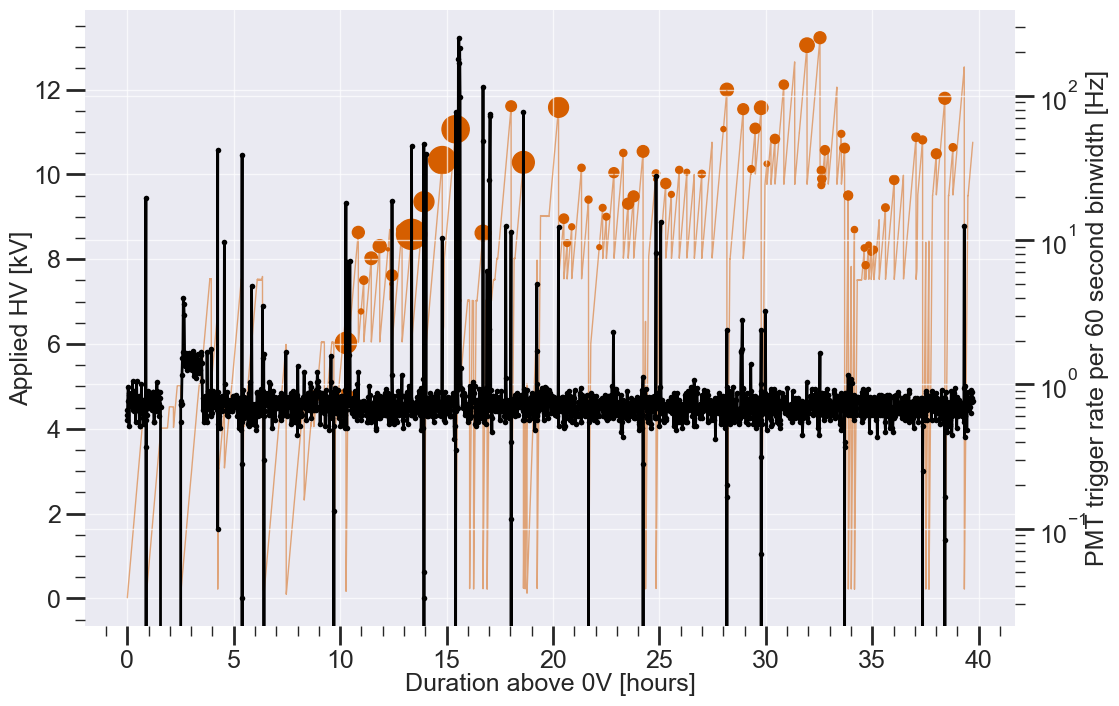

In [108]:
fig, ax = plt.subplots()

d = ana.df
mask = (d["ch3 amp"] > 2) & (d["ch3 amp"] != None)
d_ch = np.array(d[mask]["ch3 charge"])
d_sec = np.array(d[mask]["ch3 seconds"])
d_hv = np.array(d[mask]["ch3 hv"])
d_E = np.array(d[mask]["ch3 field"])

#recast time
hv_event_durs = [ana.get_duration_from_timestamp(_)/3600 for _ in d_sec]
ax.scatter(hv_event_durs, d_hv, s=list(np.array(d_ch)*20), color=colors[2], alpha=1)

ax2 = ax.twinx()
ax.plot(np.array(tdmap["dur"])/3600, tdmap["v"], color=colors[2], linewidth=1, alpha=0.5)
ax2.plot(durs, rate, 'ko-')
#ax.set_xlim([0, 5])
ax2.set_yscale('log')
ax.set_ylabel("Applied HV [kV]")
ax.set_xlabel("Duration above 0V [hours]")
ax2.set_ylabel("PMT trigger rate per 60 second binwidth [Hz]")
plt.show()


In [99]:
import time
#PMT rates

ana = anas[7]
ana.load_hv_textfiles()
ana.identify_ramps(ref='v_mon')
#an attempt to make code that will give me the HV ramp curve along with
#amplitudes and times of any charge  signals that arrive
tdmap = ana.time_duration_map
light_events = ana.get_light_triggers()
#cast the timestamps into duration space, rounding off
#a few decimal points of the nanosecond bits
#ALSO, only use one channel, as there will be double counting
#if both channels are used. They're all triggered for each event. 
ts = np.array(light_events["ch0 seconds"])
ts_ns = np.array(light_events["ch0 nanoseconds"]).astype(float)
ts_ms = ts + np.round(ts_ns/1.0e9, 3) #now its timestamps with ms precision

rate_binwidth = 60 #seconds
bins = np.arange(min(ts_ms), max(ts_ms), rate_binwidth)
timer0 = time.time()
n, bin_edges = np.histogram(ts_ms, bins=bins)
rate = np.array(n)/rate_binwidth #Hz
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
timer1 = time.time()

#how long is this?
timer0 = time.time()
durs = [ana.get_duration_from_timestamp(_)/3600 for _ in bin_centers]
timer1 = time.time()
print("Duration map took {:.2f} seconds".format(timer1 - timer0))






Duration map took 30.27 seconds


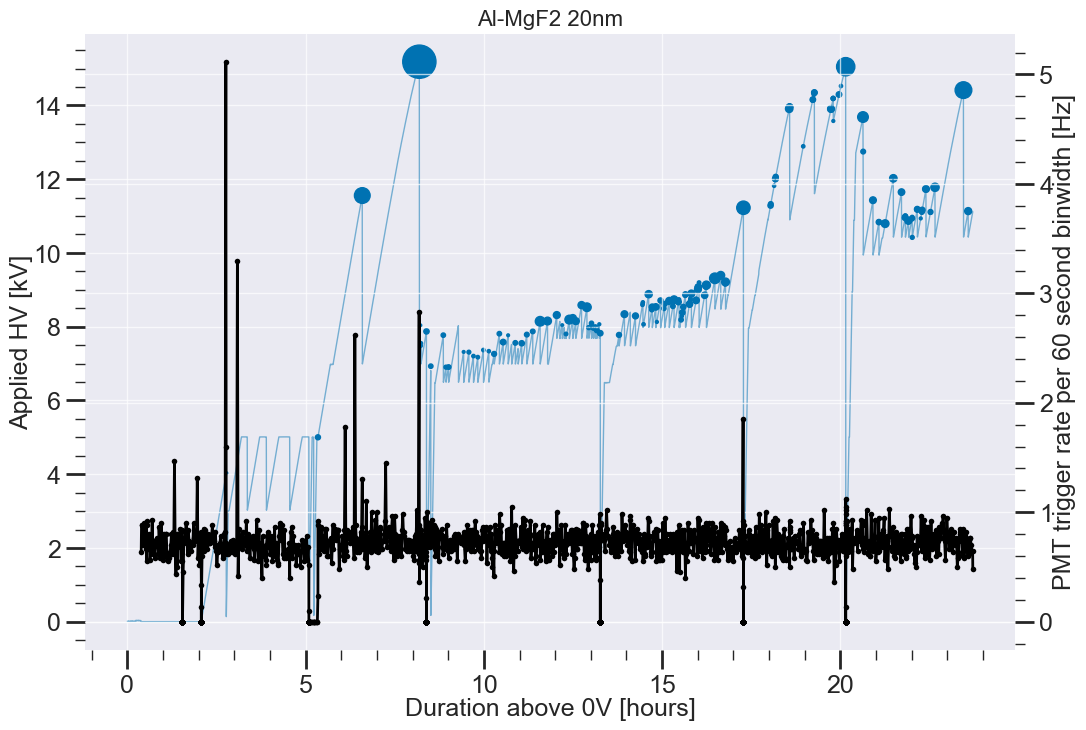

In [102]:
fig, ax = plt.subplots()

d = ana.df
mask = (d["ch3 amp"] > 2) & (d["ch3 amp"] != None)
d_ch = np.array(d[mask]["ch3 charge"])
d_sec = np.array(d[mask]["ch3 seconds"])
d_hv = np.array(d[mask]["ch3 hv"])
d_E = np.array(d[mask]["ch3 field"])

#recast time
hv_event_durs = [ana.get_duration_from_timestamp(_)/3600 for _ in d_sec]
ax.scatter(hv_event_durs, d_hv, s=list(np.array(d_ch)*20), color=colors[0], alpha=1)

ax2 = ax.twinx()
ax.plot(np.array(tdmap["dur"])/3600, tdmap["v"], color=colors[0], linewidth=1, alpha=0.5)
ax2.plot(durs, rate, 'ko-')
#ax.set_xlim([0, 5])
#ax2.set_xlim([0, 5])
ax.set_ylabel("Applied HV [kV]")
ax.set_xlabel("Duration above 0V [hours]")
ax2.set_ylabel("PMT trigger rate per 60 second binwidth [Hz]")
ax.set_title("Al-MgF2 20nm")
plt.show()


In [103]:
import time
#PMT rates

ana = anas[9]
ana.load_hv_textfiles()
ana.identify_ramps(ref='v_mon')
#an attempt to make code that will give me the HV ramp curve along with
#amplitudes and times of any charge  signals that arrive
tdmap = ana.time_duration_map
light_events = ana.get_light_triggers()
#cast the timestamps into duration space, rounding off
#a few decimal points of the nanosecond bits
#ALSO, only use one channel, as there will be double counting
#if both channels are used. They're all triggered for each event. 
ts = np.array(light_events["ch0 seconds"])
ts_ns = np.array(light_events["ch0 nanoseconds"]).astype(float)
ts_ms = ts + np.round(ts_ns/1.0e9, 3) #now its timestamps with ms precision

rate_binwidth = 1 #seconds
bins = np.arange(min(ts_ms), min(ts_ms) + 60*60*5, rate_binwidth)
timer0 = time.time()
n, bin_edges = np.histogram(ts_ms, bins=bins)
rate = np.array(n)/rate_binwidth #Hz
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
timer1 = time.time()

#how long is this?
timer0 = time.time()
durs = [ana.get_duration_from_timestamp(_)/3600 for _ in bin_centers]
timer1 = time.time()
print("Duration map took {:.2f} seconds".format(timer1 - timer0))






Duration map took 160.95 seconds


ValueError: x and y must be the same size

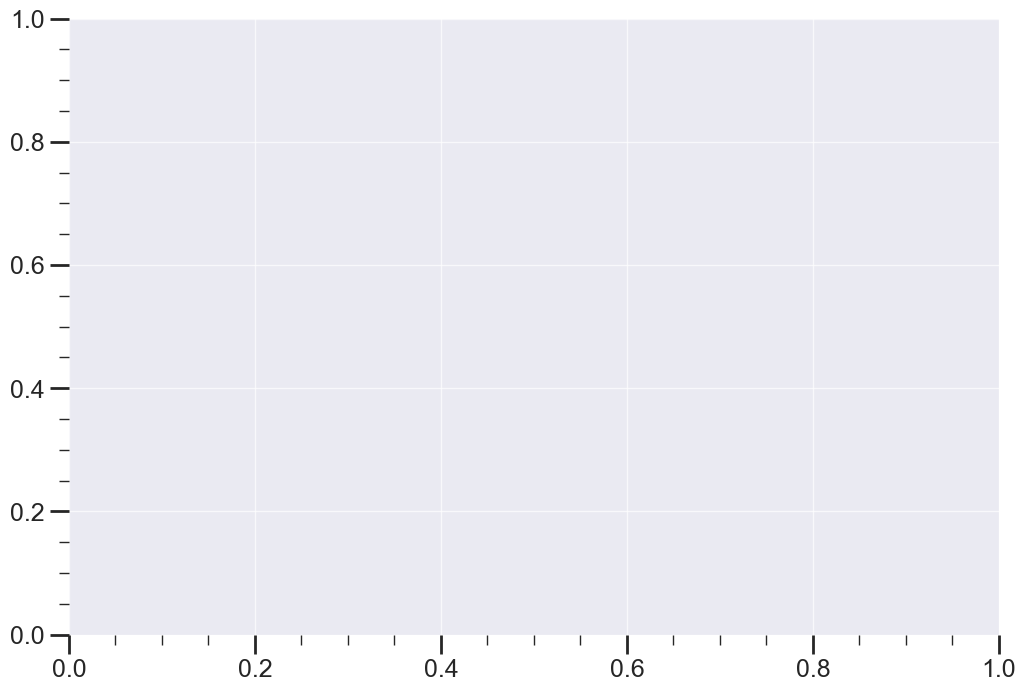

In [105]:
fig, ax = plt.subplots()

d = ana.df
mask = (d["ch3 amp"] > 2) & (d["ch3 amp"] != None)
d_ch = np.array(d[mask]["ch3 charge"])
d_sec = np.array(d[mask]["ch3 seconds"])
d_hv = np.array(d[mask]["ch3 hv"])
d_E = np.array(d[mask]["ch3 field"])

#recast time
hv_event_durs = [ana.get_duration_from_timestamp(_)/3600 for _ in d_sec]
ax.scatter(hv_event_durs, d_hv, s=list(np.array(d_ch)*20), color=colors[0], alpha=1)

ax2 = ax.twinx()
ax.plot(np.array(tdmap["dur"])/3600, tdmap["v"], color=colors[0], linewidth=1, alpha=0.5)
ax2.plot(durs, rate, 'ko-')
#ax.set_xlim([0, 5])
#ax2.set_xlim([0, 5])
ax.set_ylabel("Applied HV [kV]")
ax.set_xlabel("Duration above 0V [hours]")
ax2.set_ylabel("PMT trigger rate per 60 second binwidth [Hz]")
ax.set_title("Al-MgF2 20nm")
plt.show()
